### Transfer Pytorch weights to Keras model
Jenia Golbstein

In [1]:
import torch
from keras import backend as K
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from keras.layers import Conv2D, Input, Dense, MaxPool2D, Flatten, Lambda, BatchNormalization
from keras.models import Model
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Create dummy PyTorch model

* Model with convolution, bachnormalization and fully connected layer
* For input @ size (28x28x1) - MNIST dataset

In [2]:
class PytorchModel(nn.Module):
    def __init__(self):
        super(PytorchModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(num_features=2)
        self.fc1 = nn.Linear(13*13*2, 10)
    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 13*13*2)
        x = self.fc1(x)
        return F.softmax(x, dim=1)
    
# Load dummpy pytorch model to cpu on evaluation mode
p_model = PytorchModel()
p_model.cpu()
p_model.eval()

PytorchModel(
  (conv1): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=338, out_features=10, bias=True)
)

### Create dummy Keras model

* #### Similar architecture as the Pytorch model
* #### tensorflow backend with image_data_format="channels_last"


* Pytorch input order is (B, C, H, W). 
* Keras input order (channels_last) is (B, H, W, C)


Therefore, when you do flattening of the activations ("view" in pytorch) you have to reshape you input to be like the input in your pytorch model so the pre-trained pytorch weights will be relevant.

Also, I don't know why and if anyone can explain me this - it's necessary to do this trick before the BatchNormalization layer in keras and reshape back afterwards to (BHWC)

In [3]:
# Make sure it's "channels_last"
print(K.image_data_format()) 

channels_last


In [4]:
# Build keras model on cpu
with tf.device('/cpu:0'):
    inp = Input((28,28,1))
    x = Conv2D(2,3,activation='relu', name='conv1')(inp)
    
    # Reshaping to (BCHW)
    x = Lambda(lambda x: K.permute_dimensions(x, (0, 3, 1, 2)))(x)
    x = BatchNormalization(axis = 1, name='bn1')(x)
    
    # Reshaping back to (BHWC)
    x = Lambda(lambda x: K.permute_dimensions(x, (0, 2, 3, 1)))(x)
    x = MaxPool2D()(x)
    
    # Reshaping to (BCHW)
    x = Lambda(lambda x: K.permute_dimensions(x, (0, 3, 1, 2)))(x)
    x = Flatten()(x)
    out = Dense(10, activation='softmax',name='fc1')(x)
    k_model = Model(inp, out)

### Pytorch to Keras weights conversion

In [10]:
# pytoch weights to keras

trained_weights = p_model.state_dict()
pytorch_layers = [] # get ptroch layers names and suffixes
for x, l in zip(trained_weights, k_model.layers):
    pytorch_layers.append(x[:x.find('.')])

unique_layers = np.unique(pytorch_layers)

for layer in unique_layers:
    weights = trained_weights['{}.weight'.format(layer)].cpu().numpy() # torch weights (nf, ch, x, y)
    biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
    if 'bn' in layer:
        running_mean = trained_weights['{}.running_mean'.format(layer)].cpu().numpy()
        running_var = trained_weights['{}.running_var'.format(layer)].cpu().numpy()
        W = [weights, biases, running_mean, running_var]
    elif 'fc' in layer:
        biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
        W = [weights.T, biases]
    else:
        W = [np.moveaxis(weights, [0, 1], [3, 2]), biases] # transpose to (x, y, ch, nf) keras version
    k_model.get_layer(layer).set_weights(W)

### Compare the output of the 2 models on randomly uniformed data

max difference: 4.455447e-06 
sum of difffernces: -4.7683716e-07


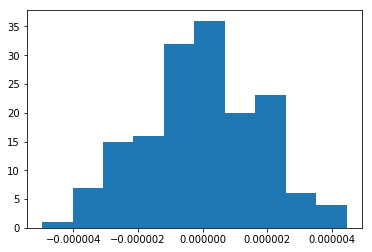

In [15]:
batch_size = 16

keras_input = np.random.random((batch_size, 28, 28, 1)).astype('float32')
pytorch_input = torch.from_numpy(keras_input.transpose(0,-1,1,2))

p_out = p_model(pytorch_input.cpu())
k_out = k_model.predict(keras_input)

y = torch.from_numpy(k_out) - p_out
y = y.detach().numpy().flatten()
plt.hist(y);
print('max difference:', y.max(), '\nsum of difffernces:', y.sum())